<a href="https://colab.research.google.com/github/troncosofranco/ML-algorithms/blob/main/Car_price_w_Bayesian_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In the present notebook the prediction of car price using Bayesian Optimization is performed. The dataset was obtained from [Kaggle](https://www.kaggle.com/datasets/sidharth178/car-prices-dataset), corresponding to UK price car.

#1. Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

from sklearn.feature_selection import mutual_info_regression
from xgboost import plot_importance
import matplotlib.pyplot as plt
from matplotlib import pyplot,figure
from scipy.ndimage.measurements import mean
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor,AdaBoostRegressor
from sklearn.linear_model import BayesianRidge,RidgeCV,Ridge,Lasso,LassoCV,ElasticNet
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.preprocessing import StandardScaler,OneHotEncoder,scale,LabelEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer,SimpleImputer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA
import lightgbm as lgb
from mlxtend.regressor import StackingRegressor
from sklearn.compose import make_column_selector as selector, ColumnTransformer

#skopt: scikit-optimize
!pip install scikit-optimize 
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from scipy.stats import skew

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

import time
start_time = time.time()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 100 kB 7.5 MB/s 


#2. Data Processing

In [2]:
#load data
df_train = pd.read_csv('train.csv',index_col="ID")
df_test = pd.read_csv('test.csv',index_col="ID")

In [3]:
df_train.head()
#df_train.shape
#df_test.columns

#Data types of columns
#df_test.dtypes
df_train['Doors'].dtypes

dtype('O')

In [4]:
#statistic summary of numeric variables in dataframe
# count: number of NoN-empty rows in a feature.
# mean: mean value of that feature.
# std: Standard Deviation Value of that feature.
# min: minimum value of that feature.
# max: maximum value of that feature.
# 25%, 50%, and 75%: percentile of each features
#df_train.drop(['ID'], axis=1, inplace=True)
df_train.describe()

,Price,Prod. year,Cylinders,Airbags
count,1.923700e+04,19237.000000,19237.000000,19237.000000
mean,1.855593e+04,2010.912824,4.582991,6.582627
std,1.905813e+05,5.668673,1.199933,4.320168
min,1.000000e+00,1939.000000,1.000000,0.000000
25%,5.331000e+03,2009.000000,4.000000,4.000000
50%,1.317200e+04,2012.000000,4.000000,6.000000
75%,2.207500e+04,2015.000000,4.000000,12.000000
max,2.630750e+07,2020.000000,16.000000,16.000000


In [5]:
#dropping duplicate values 
df_train =df_train.drop_duplicates()
df_test =df_test.drop_duplicates()

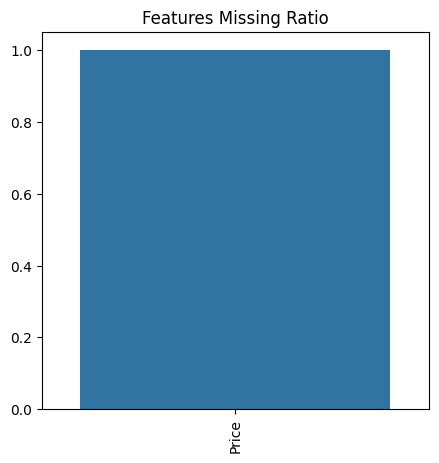

In [6]:
#check for missing values 
def missing_data(df):
  missing_data = ((df.isnull().sum())/len(df))
  missing_data = missing_data[missing_data.values > 0].sort_values()

  missing_data.head()
  #Visualize the missing value ratio 
  fig = plt.figure(figsize=(5,5), dpi = 100)
  sns.barplot(x = missing_data.index, y = missing_data.values) 
  plt.xticks(rotation=90)
  plt.title('Features Missing Ratio')
  plt.show()

#missing_data(df_train)
missing_data(df_test)



Missing values in `Price` column in test dataset. No missing values in train dataset.

 # 2.1. Maintain data integrity

In [7]:
def replace_NA(df):
    #Replace NA data with 0 in price column 
    df[['Price']] = df[['Price']].fillna(value=0)
    return df

df_test = replace_NA(df_test)

In [8]:
df_train['Doors'].value_counts()

04-May    14855
02-Mar      746
>5          124
Name: Doors, dtype: int64

In [9]:
#Door feature correction
def door_correction(df):
  df.loc[df['Doors'] == '04-May', 'Doors'] = 4
  df.loc[df['Doors'] == '02-Mar', 'Doors'] = 2
  df.loc[df['Doors'] == '>5', 'Doors'] = 5
  df["Doors"] = df["Doors"].astype(int)
  return df

door_correction(df_train)
door_correction(df_test)
#df_train['Doors'].value_counts()


,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price
ID,,,,,,,,,,,,,,,,,
44020629,-,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,2.0 Turbo,0 km,4,Manual,Front,2,Left wheel,Grey,10,0.0
45784798,-,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,2.4,26000 km,4,Tiptronic,Front,4,Left wheel,Grey,10,0.0
45800257,-,NISSAN,Tiida,2005,Sedan,No,Petrol,1.5,168000 km,4,Automatic,Front,4,Right-hand drive,Sky blue,8,0.0
45797981,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,3.2,143000 km,6,Automatic,4x4,4,Left wheel,Blue,12,0.0
45814303,-,OPEL,Astra,1993,Hatchback,No,Petrol,1.6,200000 km,4,Manual,Front,4,Left wheel,Black,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45787008,645,TOYOTA,Prius,2011,Sedan,Yes,Petrol,1.8,283000 km,4,Automatic,Front,4,Left wheel,White,4,0.0
44824410,1357,FIAT,Stilo,2004,Universal,No,Petrol,1.6,164000 km,4,Manual,Front,4,Left wheel,Blue,6,0.0
45682346,-,BMW,528 F10,2012,Sedan,Yes,Petrol,2.8 Turbo,156000 km,4,Tiptronic,Front,4,Left wheel,Black,6,0.0


In [10]:
#Levy Feature correction
def levy_correction(df):
  df.loc[df['Levy'] == '-', 'Levy'] = 0
  df['Levy'] = df['Levy'].astype('int')
  return df

levy_correction(df_test)
levy_correction(df_train)

#df_test['Levy'].value_counts()


,Price,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Engine volume,Mileage,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags
ID,,,,,,,,,,,,,,,,,
45654403,13328,1399,LEXUS,RX 450,2010,Jeep,Yes,Hybrid,3.5,186005 km,6.0,Automatic,4x4,4,Left wheel,Silver,12
44731507,16621,1018,CHEVROLET,Equinox,2011,Jeep,No,Petrol,3,192000 km,6.0,Tiptronic,4x4,4,Left wheel,Black,8
45774419,8467,0,HONDA,FIT,2006,Hatchback,No,Petrol,1.3,200000 km,4.0,Variator,Front,4,Right-hand drive,Black,2
45769185,3607,862,FORD,Escape,2011,Jeep,Yes,Hybrid,2.5,168966 km,4.0,Automatic,4x4,4,Left wheel,White,0
45809263,11726,446,HONDA,FIT,2014,Hatchback,Yes,Petrol,1.3,91901 km,4.0,Automatic,Front,4,Left wheel,Silver,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45760891,470,645,TOYOTA,Prius,2011,Hatchback,Yes,Hybrid,1.8,307325 km,4.0,Automatic,Front,4,Left wheel,Silver,12
45798355,8467,0,MERCEDES-BENZ,CLK 200,1999,Coupe,Yes,CNG,2.0 Turbo,300000 km,4.0,Manual,Rear,2,Left wheel,Silver,5
45778856,15681,831,HYUNDAI,Sonata,2011,Sedan,Yes,Petrol,2.4,161600 km,4.0,Tiptronic,Front,4,Left wheel,Red,8


In [11]:
def split(df):
  #Engine Feature correction
  df[['Engine', 'Turbo']] = df['Engine volume'].str.split(' ', 1, expand=True) 
  
  #Mileage Feature correction
  df[['kage', 'km']] = df['Mileage'].str.split(' ', 1, expand=True) 

  df.drop(['Engine volume', 'Turbo','km','Mileage'], axis=1, inplace=True)

  df["Engine"] = df["Engine"].astype(float)
  df["kage"] = df["kage"].astype(int)
  
  return df

split(df_train)
split(df_test)


,Levy,Manufacturer,Model,Prod. year,Category,Leather interior,Fuel type,Cylinders,Gear box type,Drive wheels,Doors,Wheel,Color,Airbags,Price,Engine,kage
ID,,,,,,,,,,,,,,,,,
44020629,0,VOLKSWAGEN,Golf,2012,Hatchback,No,Diesel,4,Manual,Front,2,Left wheel,Grey,10,0.0,2.0,0
45784798,0,HYUNDAI,Sonata,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,4,Left wheel,Grey,10,0.0,2.4,26000
45800257,0,NISSAN,Tiida,2005,Sedan,No,Petrol,4,Automatic,Front,4,Right-hand drive,Sky blue,8,0.0,1.5,168000
45797981,975,VOLVO,XC90,2012,Jeep,Yes,Petrol,6,Automatic,4x4,4,Left wheel,Blue,12,0.0,3.2,143000
45814303,0,OPEL,Astra,1993,Hatchback,No,Petrol,4,Manual,Front,4,Left wheel,Black,0,0.0,1.6,200000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45787008,645,TOYOTA,Prius,2011,Sedan,Yes,Petrol,4,Automatic,Front,4,Left wheel,White,4,0.0,1.8,283000
44824410,1357,FIAT,Stilo,2004,Universal,No,Petrol,4,Manual,Front,4,Left wheel,Blue,6,0.0,1.6,164000
45682346,0,BMW,528 F10,2012,Sedan,Yes,Petrol,4,Tiptronic,Front,4,Left wheel,Black,6,0.0,2.8,156000


In [12]:
#df_train.describe()

In [13]:
from pandas.plotting import scatter_matrix
#scatter_matrix(df_train, alpha=0.2, figsize=(20, 20), diagonal='kde')

In [14]:
#Categorical or ordinal variables?
df_train.head()


#df_train['Fuel type'].value_counts()[:].plot(kind='barh', figsize=(10,15))

cat_features = ['Manufacturer', 'Model','Category','Leather interior', 
                'Fuel type', 'Gear box type', 'Drive wheels',
                'Wheel']

for feature in cat_features:
  print(feature, ':', df_train[feature].unique())

#All are categorical features

Manufacturer : ['LEXUS' 'CHEVROLET' 'HONDA' 'FORD' 'HYUNDAI' 'TOYOTA' 'MERCEDES-BENZ'
 'OPEL' 'PORSCHE' 'BMW' 'JEEP' 'VOLKSWAGEN' 'AUDI' 'RENAULT' 'NISSAN'
 'SUBARU' 'DAEWOO' 'KIA' 'MITSUBISHI' 'SSANGYONG' 'MAZDA' 'GMC' 'FIAT'
 'INFINITI' 'ALFA ROMEO' 'SUZUKI' 'ACURA' 'LINCOLN' 'VAZ' 'GAZ' 'CITROEN'
 'LAND ROVER' 'MINI' 'DODGE' 'CHRYSLER' 'JAGUAR' 'ISUZU' 'SKODA'
 'DAIHATSU' 'BUICK' 'TESLA' 'CADILLAC' 'PEUGEOT' 'BENTLEY' 'VOLVO' 'სხვა'
 'HAVAL' 'HUMMER' 'SCION' 'UAZ' 'MERCURY' 'ZAZ' 'ROVER' 'SEAT' 'LANCIA'
 'MOSKVICH' 'MASERATI' 'FERRARI' 'SAAB' 'LAMBORGHINI' 'ROLLS-ROYCE'
 'PONTIAC' 'SATURN' 'ASTON MARTIN' 'GREATWALL']
Model : ['RX 450' 'Equinox' 'FIT' ... 'E 230 124' 'RX 450 F SPORT' 'Prius C aqua']
Category : ['Jeep' 'Hatchback' 'Sedan' 'Microbus' 'Goods wagon' 'Universal' 'Coupe'
 'Minivan' 'Cabriolet' 'Limousine' 'Pickup']
Leather interior : ['Yes' 'No']
Fuel type : ['Hybrid' 'Petrol' 'Diesel' 'CNG' 'Plug-in Hybrid' 'LPG' 'Hydrogen']
Gear box type : ['Automatic' 'Tiptronic' 'Varia

#b. Cardinality Reduction

In [15]:
#Check cardinality

#x = df_train.copy()
#Feature to reduce cardinality: Manufacturer, Model, Category, Fuel type
#threshold: categorical values lower than threshold (%) are removed according to value counts percentage
def cardinality_red(df,column,threshold):
  value_list = df[column].value_counts(normalize=True)*1000
  cat_values_list = list(filter(lambda item: item > threshold, value_list))

  #Top most common features
  cat_selected = value_list.index[0:len(cat_values_list)]
  df[column]=df[column].apply(lambda x: x if x in cat_selected else 'Other')
  
#[Manufacturer, Model, Category, Fuel type]

#Manufacturer, Model, Category, Fuel type
#df_train
cardinality_red(df_train,'Manufacturer',15)
cardinality_red(df_train,'Category',15)
cardinality_red(df_train,'Model',15)
cardinality_red(df_train,'Fuel type',15)

#df_test
cardinality_red(df_test,'Manufacturer',15)
cardinality_red(df_test,'Category',15)
cardinality_red(df_test,'Model',15)
cardinality_red(df_test,'Fuel type',15)


#x['Category'].value_counts().sort_values().plot(kind = 'barh',figsize=(15,15))



##c) Label encoding

In [16]:
from sklearn.preprocessing import LabelEncoder
def label_encoder(df):
  # get all categorical columns in the dataframe
  cat_cols = [col for col in df.columns if df[col].dtype=="O"]
  lb_make = LabelEncoder()
  for item in cat_cols:
      df[item] = lb_make.fit_transform(df[item])
  return df

df_train = label_encoder(df_train)
df_test = label_encoder(df_test)

In [17]:
#Check for missing values
#df_test.isna().sum()

#No missing values in df_train or df_test

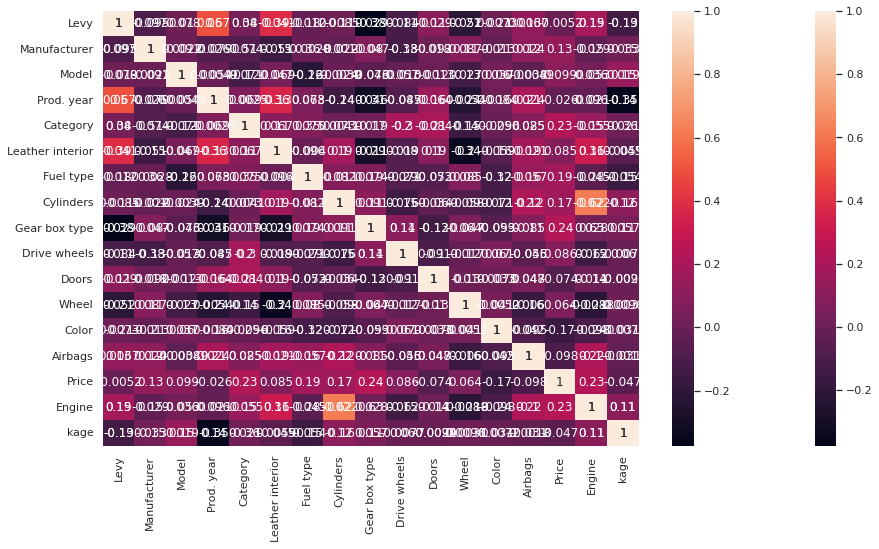

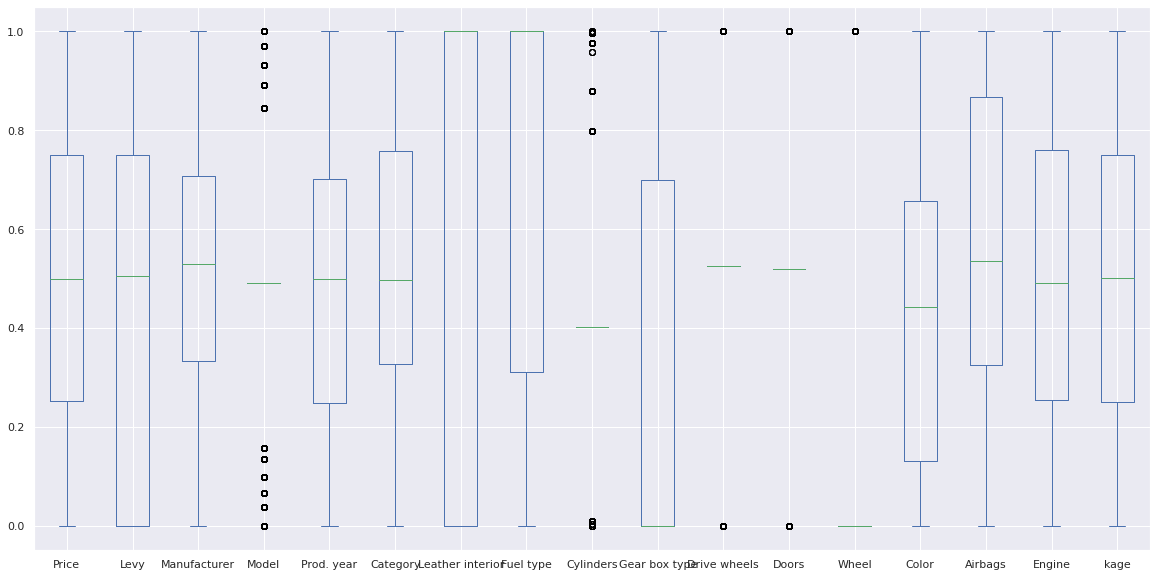

In [18]:
from sklearn.preprocessing import QuantileTransformer
def quantile_transf(df):
  column_names = list(df.columns)

  x=df
  quantile  = QuantileTransformer()
  X = quantile.fit_transform(x)

  df_quantile=quantile.transform(X)
  df_quantile=pd.DataFrame(X)
  df_quantile.columns = column_names
  corrmat_quantile=df_quantile.corr()
  sns.set(rc = {'figure.figsize':(15,8)})
  sns.heatmap(corrmat_quantile, annot=True)
  return df_quantile

df_train = quantile_transf(df_train)
df_test = quantile_transf(df_test)

ax = df_train.plot.box(figsize=(25,15))

#3. Feature Engineering

In [19]:
from sklearn import preprocessing

#MinMax scaker
def min_max_scaler(df):
  col_names = list(df.columns)
  x = df.values #returns a numpy array
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  df = pd.DataFrame(x_scaled, columns=col_names)
  return df

df_train = min_max_scaler(df_train)
df_test = min_max_scaler(df_test)



In [20]:
#Alternative to correlation matrix heatmap
def make_scores(df):
    
    X = df.select_dtypes('float64').drop('Price',axis = 1)
    
    #Target label 
    y = df.Price
    
    discrete_features = X.dtypes == 'float64'
    
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="Price Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    
    return mi_scores

mi_scores = make_scores(df_train)
mi_scores  # show a few features with their MI scores

Levy                0.562783
kage                0.404172
Airbags             0.394961
Prod. year          0.364576
Manufacturer        0.311597
Model               0.270283
Engine              0.261249
Gear box type       0.194268
Fuel type           0.178024
Leather interior    0.152098
Category            0.147271
Drive wheels        0.091741
Wheel               0.076898
Cylinders           0.069372
Color               0.064247
Doors               0.014939
Name: Price Scores, dtype: float64

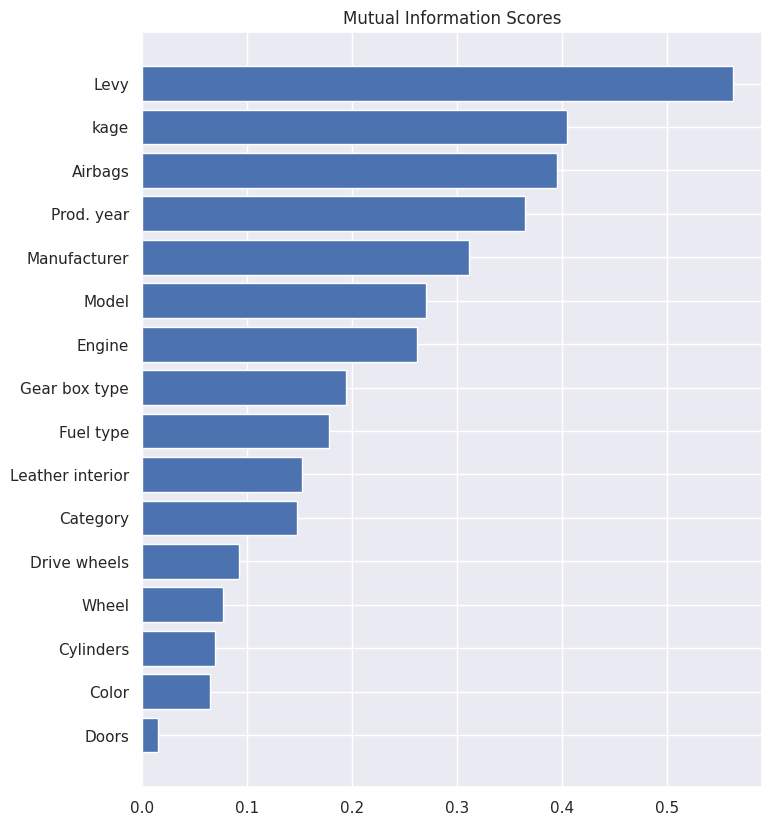

In [21]:
#Plot scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 10))
plot_mi_scores(mi_scores)

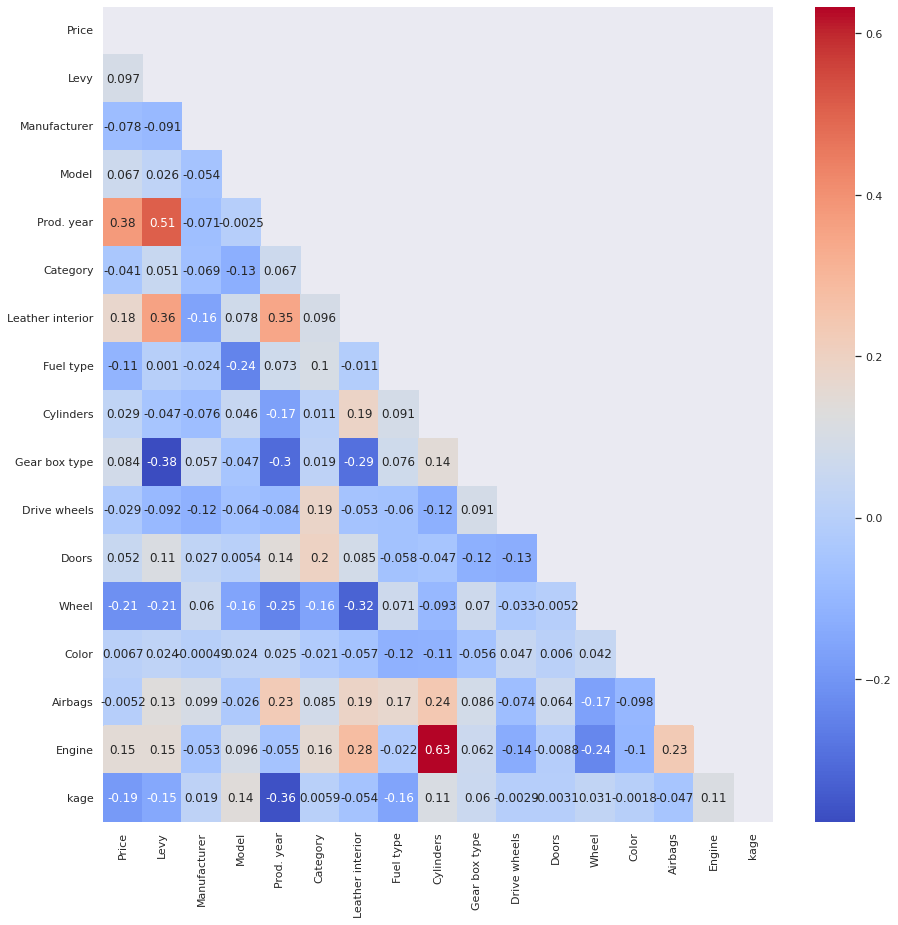

In [22]:
#Plot the correlation matrix for numeric data
def corr_heatmap(df):
  df_corr = df.corr(method = 'pearson')
  mask = np.triu(np.ones_like(df.corr()))
  fig, ax = plt.subplots(figsize=(15,15)) 
  sns.heatmap(df_corr, cmap="coolwarm", annot=True, mask= mask, ax=ax)
  plt.show()

corr_heatmap(df_train)

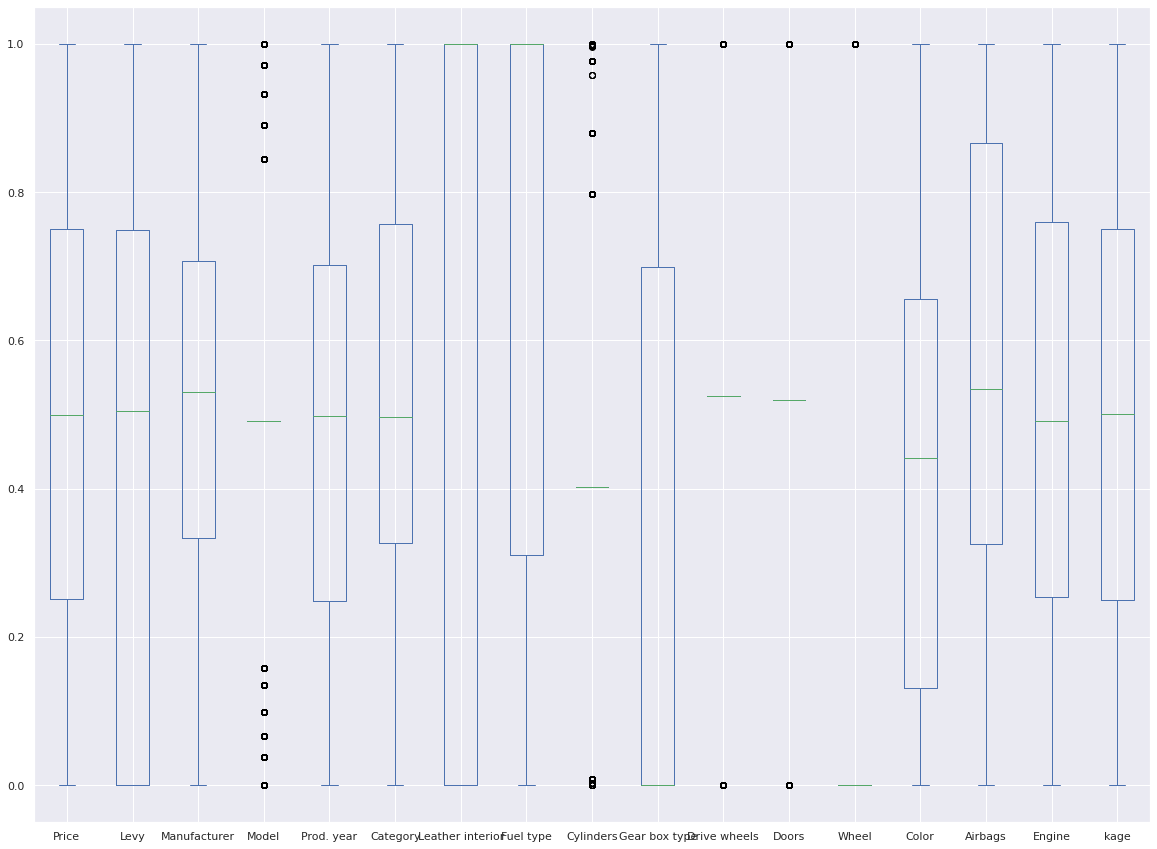

In [23]:

ax = df_train.plot.box(figsize=(20,15))


In [24]:
#drop features with low correlation coefficient
low_corr_features = ['Levy', 'Manufacturer', 'Model', 'Category','Cylinders', 'Gear box type', 'Drive wheels','Doors','Color','Airbags']
df_train = df_train.drop(low_corr_features, axis=1)
df_test = df_test.drop(low_corr_features, axis=1)
#scatter_matrix(df_train, alpha=0.2, figsize=(20, 20), diagonal='kde')

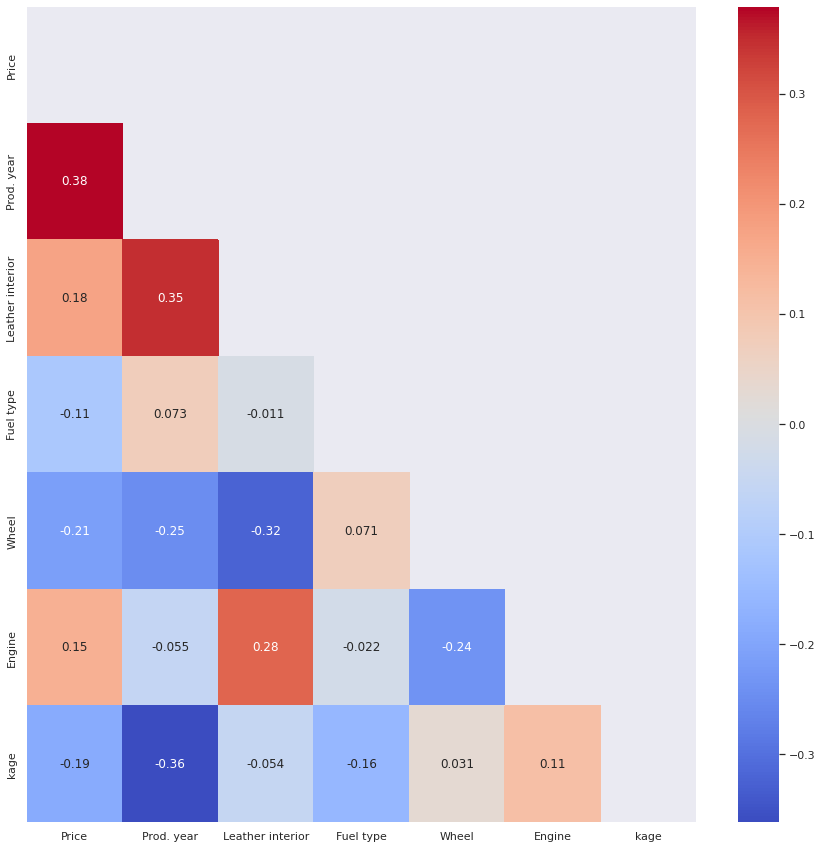

In [28]:
corr_heatmap(df_train)
#df_train.head()

#3. Exploratory Data Analysis (EDA)

##a) Histograms

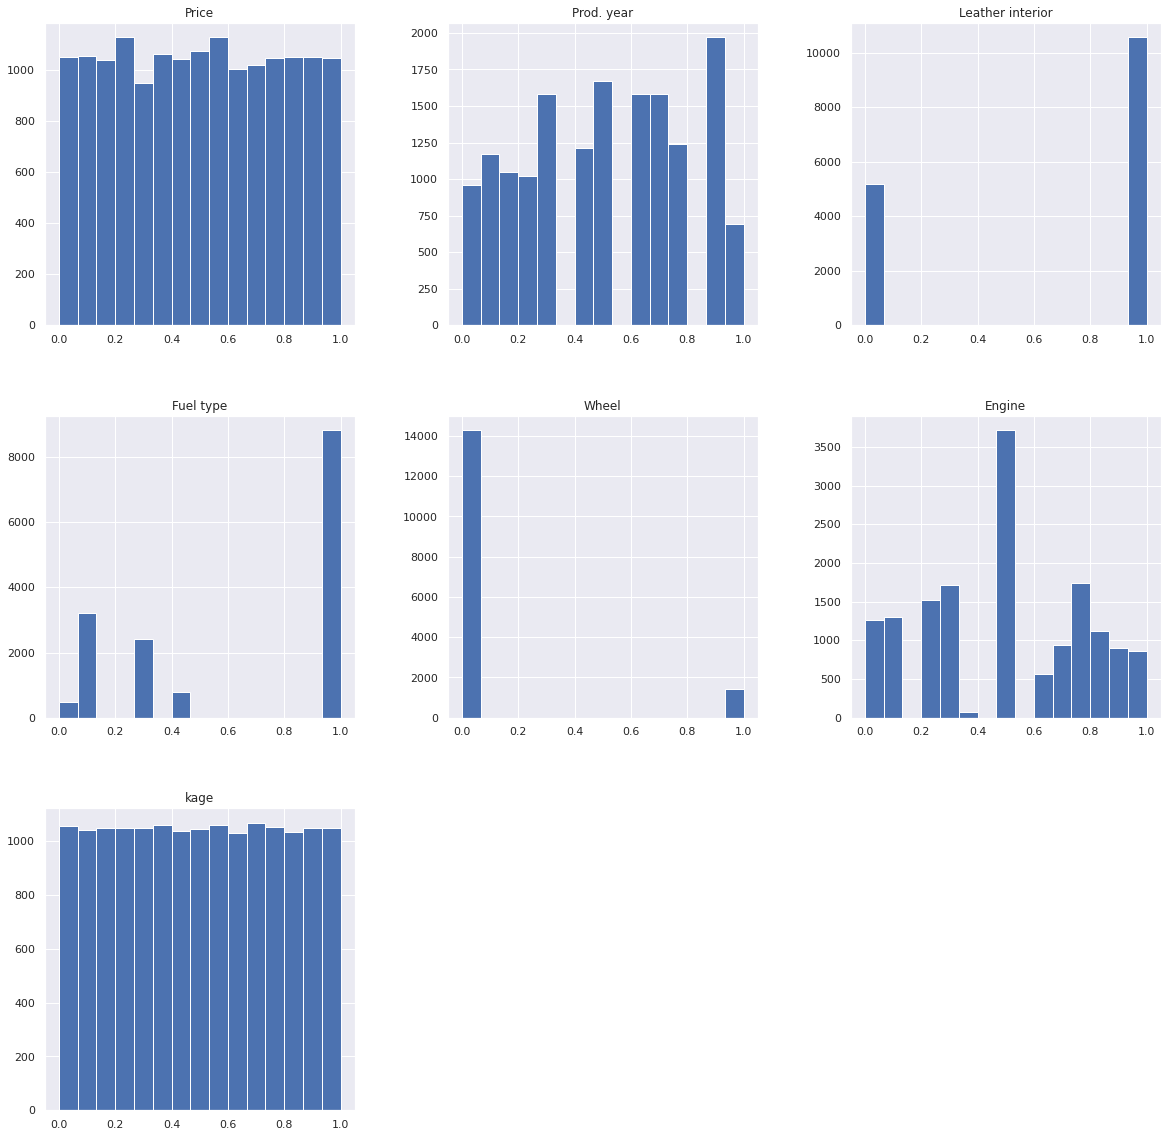

In [32]:
#histogram for each feature
df_train.hist(bins=15,figsize=(20,20))
plt.show()

##b) Scatter Matrix

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd0a8466d50>,
      dtype=object)

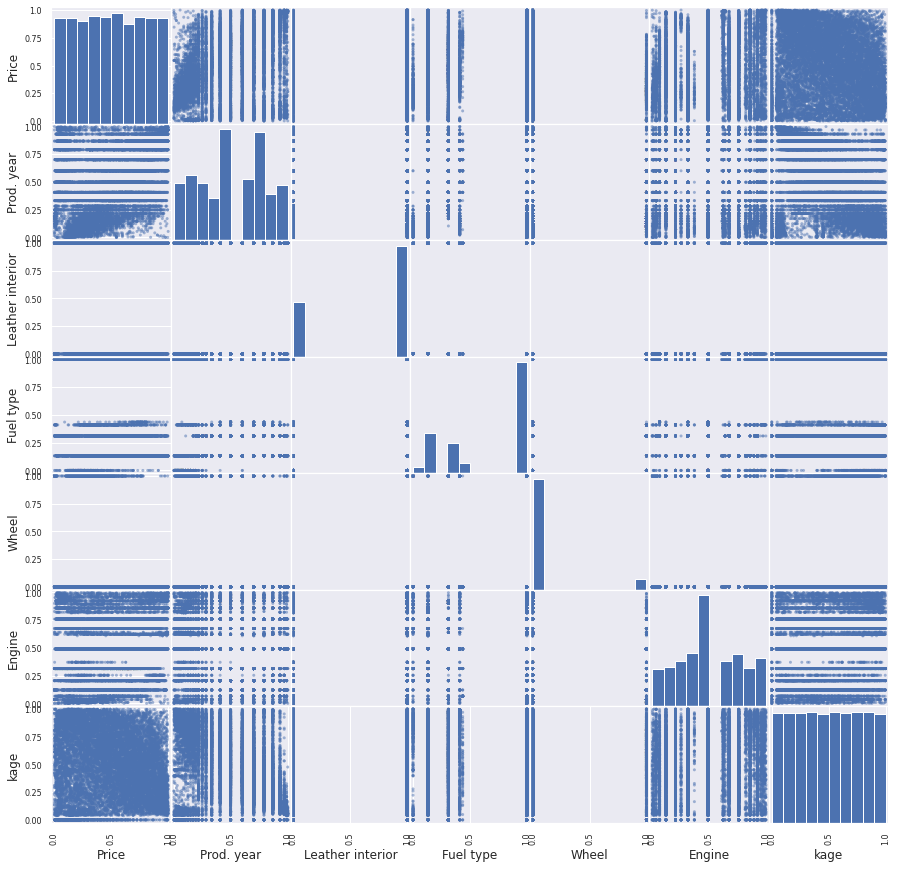

In [34]:
scatter_matrix(df_train,figsize=(15,15))

##c) Boxplot

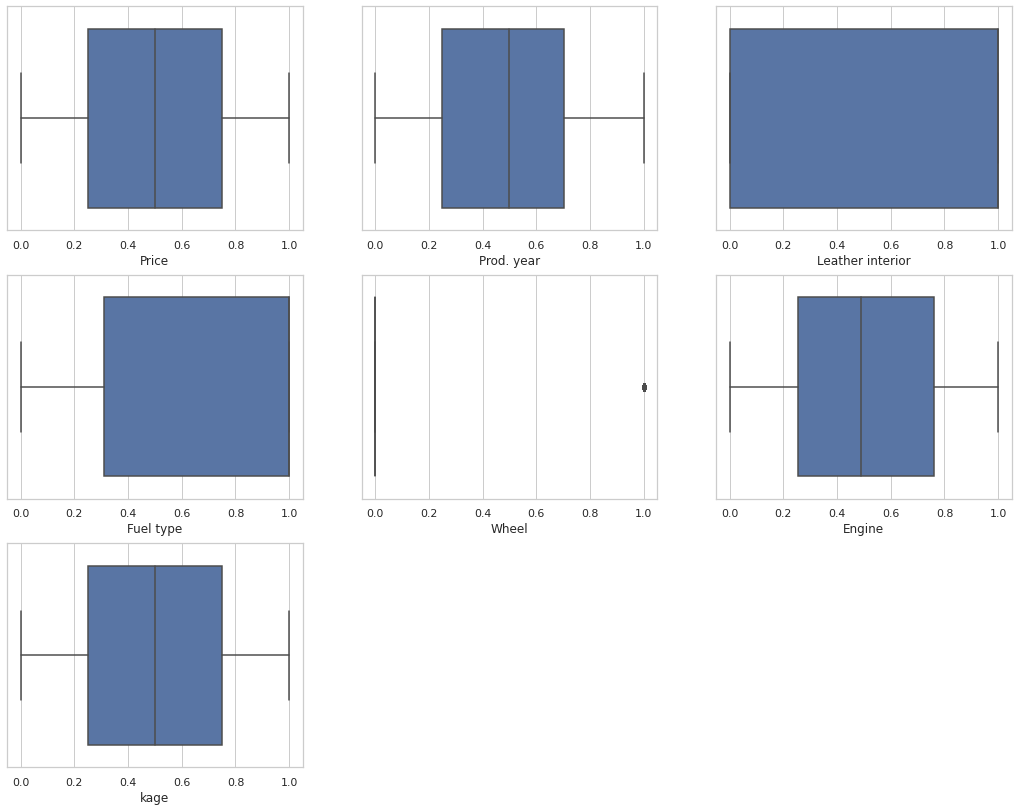

In [35]:
#Botplot for outliers identification

plt.figure(figsize=(18,14))
sns.set_style(style='whitegrid')

plt.subplot(3,3,1)
sns.boxplot(x='Price',data=df_train)
plt.subplot(3,3,2)
sns.boxplot(x='Prod. year',data=df_train)
plt.subplot(3,3,3)
sns.boxplot(x='Leather interior',data=df_train)
plt.subplot(3,3,4)
sns.boxplot(x='Fuel type',data=df_train)
plt.subplot(3,3,5)
sns.boxplot(x='Wheel',data=df_train)
plt.subplot(3,3,6)
sns.boxplot(x='Engine',data=df_train)
plt.subplot(3,3,7)
sns.boxplot(x='kage',data=df_train)



#4. Model Selection
The top 5 models are selected by evaluating their cross-validation score without tuning.Then, the Bayesian optimizationm method is adopted to tune the top 5 models, producing the final result by averaging result.

In [37]:
#Train_test split

X = df_train.copy()
y = X.pop('Price')

#cross-validation and evaluate model performance 
kfold = KFold(n_splits=5, shuffle=True, random_state = 888)

In [38]:
#Define a function that evaluate the performance of each candidate models
def model_selection(models,X,y,cv):

  initial_r2 = dict()
  initial_rmse = dict()

  for i in models:

    #Use cross-validation for evaluating model performance
    r2 = np.mean(cross_val_score(i,X,y, cv = cv, scoring = 'r2'))
    rmse = np.mean(cross_val_score(i,X,y, cv = cv, scoring = 'neg_root_mean_squared_error'))*-1

    initial_r2[i] = "%.3g"%r2
    initial_rmse[i] = "%.3g"%rmse

    inital_rmse_df = pd.DataFrame.from_dict(initial_rmse, orient='index',columns=['RMSE'])
    initial_r2_df = pd.DataFrame.from_dict(initial_r2, orient='index',columns=['r2'])    
    

  return pd.concat([initial_r2_df,inital_rmse_df], axis = 1)

#Store candidate models in a list
models = [xgb.XGBRegressor(objective = 'reg:squarederror'),
          lgb.LGBMRegressor(),
          GradientBoostingRegressor(),
          AdaBoostRegressor(),
          KNeighborsRegressor(),
          RandomForestRegressor(),
          BayesianRidge(compute_score = True),
          Ridge(alpha = 0.0001),
          Lasso(alpha = 0.0001),
          ElasticNet(alpha = 0.0001),
          SVR()]

print(model_selection(models,X,y,5))

                                               r2   RMSE
XGBRegressor(objective='reg:squarederror')  0.375  0.228
LGBMRegressor()                             0.427  0.218
GradientBoostingRegressor()                 0.374  0.228
AdaBoostRegressor()                         0.248  0.249
KNeighborsRegressor()                       0.346  0.233
RandomForestRegressor()                      0.38  0.227
BayesianRidge(compute_score=True)           0.201  0.258
Ridge(alpha=0.0001)                         0.201  0.258
Lasso(alpha=0.0001)                         0.201  0.258
ElasticNet(alpha=0.0001)                    0.201  0.258
SVR()                                       0.333  0.235


In [39]:
#Bayesian optimization function
def hyper_tuning(model,param,cv,X,y):
    
     if param:
         #Find the best parameter by cross validation
         tuning = BayesSearchCV(estimator = model,
                                search_spaces = param,
                                verbose = -1,
                                n_iter = 50)
         tuning.fit(X,y)
     #using the optimal parameter
     tuned_model = model.set_params(**tuning.best_params_)
     tuned_model.fit(X,y)
   
     return tuned_model

##4.1. Gradient Boosting Regressor

In [40]:
#Create a parameter grid 
gbm_grid = {
     'learning_rate':Real(1e-2,1e-1,'log-uniform'),
     'max_depth':(2,15),
     'n_estimators':(100,3000),
     'subsample':Real(0.1,1.0,'log-uniform'),
     'max_features':Real(0.1,1.0,'log-uniform')
     }

gbm_model = hyper_tuning(GradientBoostingRegressor(),gbm_grid,kfold,X,y)

In [41]:
gbm_model.fit(X,y)

GradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_features=0.1,
                          n_estimators=1442)

In [42]:
#Define a function that evaluate the performance of each candidate models
def bayesian_opt_metrics(models,X,y,cv):
  initial_r2 = dict()
  initial_rmse = dict()
  for i in models:
    #Use cross-validation for evaluating model performance
    r2 = np.mean(cross_val_score(i,X,y, cv = cv, scoring = 'r2'))
    rmse = np.mean(cross_val_score(i,X,y, cv = cv, scoring = 'neg_root_mean_squared_error'))*-1

    initial_r2[i] = "%.3g"%r2
    initial_rmse[i] = "%.3g"%rmse

    inital_rmse_df = pd.DataFrame.from_dict(initial_rmse, orient='index',columns=['RMSE'])
    initial_r2_df = pd.DataFrame.from_dict(initial_r2, orient='index',columns=['r2'])    
    
  return pd.concat([initial_r2_df,inital_rmse_df], axis = 1)

#Define model to obtain metrics
models = [GradientBoostingRegressor(learning_rate=0.01, max_depth=8, max_features=0.1,
                          n_estimators=1442)]
          

print(model_selection(models,X,y,5))

                                                       r2   RMSE
GradientBoostingRegressor(learning_rate=0.01, m...  0.442  0.215


##4.2. XGBRegressor

In [43]:
#Create a parameter grid 
xgb_grid = {
     'n_estimators':(100,3000),
     'max_depth':(2,15),
     "colsample_bytree":Real(0.1,1,'log-uniform'),
     'colsample_bylevel':Real(0.1,1,'log-uniform'),
     'colsample_bynode':Real(0.1,1,'log-uniform'),
     "subsample" : Real(0.1,1,'log-uniform'),
     'learning_rate' : Real(1e-2,1e-1,'log-uniform'),
     'reg_lambda':Real(1e-6,1,'log-uniform'),
     'min_child_weight':(1,10,'uniform'),
     'gamma' :Real(1e-6,1e+2,'log-uniform'),
     'reg_alpha':Real(1e-9,1,'log-uniform'),
     'reg_lambda':Real(1e-9,1,'log-uniform')
 }

# #Find the best parameter by cross validation
xgb_model = hyper_tuning(xgb.XGBRegressor(objective = 'reg:squarederror'),xgb_grid,kfold,X,y)

In [44]:
xgb_model.fit(X,y)

XGBRegressor(colsample_bylevel=0.32537915592496347, colsample_bynode=0.1,
             colsample_bytree=1.0, gamma=4.071551237922103e-05,
             learning_rate=0.01, max_depth=15, min_child_weight=10,
             n_estimators=3000, objective='reg:squarederror',
             reg_alpha=0.017089978128693496, reg_lambda=0.004646622771593122,
             subsample=1.0)

In [46]:
models = [xgb.XGBRegressor(colsample_bylevel=0.32537915592496347, colsample_bynode=0.1,
             colsample_bytree=1.0, gamma=4.071551237922103e-05,
             learning_rate=0.01, max_depth=15, min_child_weight=10,
             n_estimators=3000, objective='reg:squarederror',
             reg_alpha=0.017089978128693496, reg_lambda=0.004646622771593122,
             subsample=1.0)]
          

print(model_selection(models,X,y,5))

                                                       r2   RMSE
XGBRegressor(colsample_bylevel=0.32537915592496...  0.443  0.215


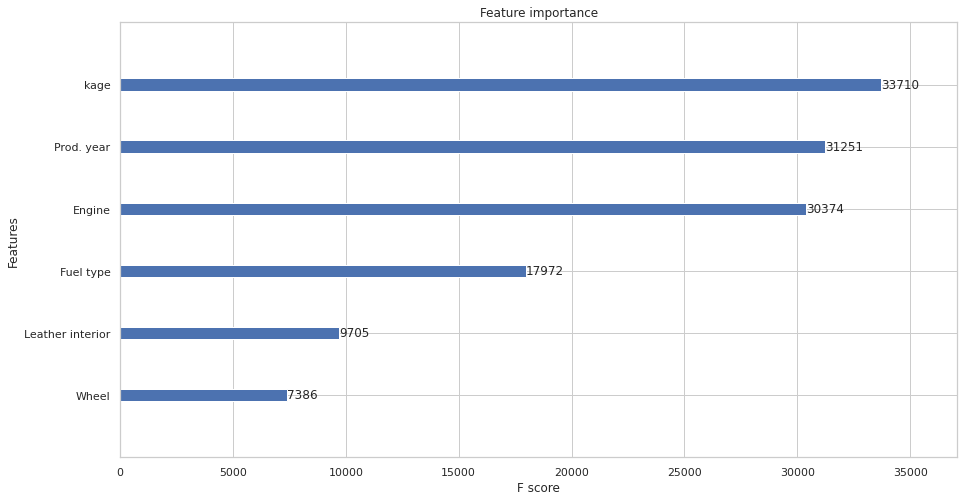

In [47]:
xgb_model.fit(X,y,eval_metric=["rmse"],
              verbose=False)

#Fature importance of the fitted xgb model
plot_importance(xgb_model.fit(X,y), max_num_features=20)
plt.show()

#4.3. Light Gradient Boost

In [49]:
#Create a parameter grid 
lgb_grid = {
     'num_iterations':Integer(100,2000),
     'max_bin':Integer(2,250),
     'min_data_in_bin':Integer(1,10),
     'learning_rate':Real(1e-2,1e-1,'log-uniform'),
     'subsample':Real(0.1,1,'log-uniform'),
     'colsample_bytree':Real(0.1,1,'log-uniform'),
     'max_depth':Integer(2,15),
     'num_leaves':Integer(2,300)
 }

#Find the best parameter by cross validation
lgb_model = hyper_tuning(lgb.LGBMRegressor(),lgb_grid,kfold,X,y)

In [50]:
lgb_model.fit(X,y)

LGBMRegressor(colsample_bytree=0.9879968468692504, learning_rate=0.01,
              max_bin=166, max_depth=9, min_data_in_bin=2, num_iterations=1082,
              num_leaves=198, subsample=0.7305289663009057)

In [52]:
models = [lgb.LGBMRegressor(colsample_bytree=0.9879968468692504, learning_rate=0.01,
              max_bin=166, max_depth=9, min_data_in_bin=2, num_iterations=1082,
              num_leaves=198, subsample=0.7305289663009057)]
          

print(model_selection(models,X,y,5))

                                                       r2   RMSE
LGBMRegressor(colsample_bytree=0.98799684686925...  0.433  0.217


#4.3. Elastic Net

In [53]:
#Create a parameter grid 
elastic_grid = {'max_iter':[10000],
                 'l1_ratio':Real(1e-3,1,'log-uniform'),
                 'alpha':Real(1e-6,100,'log-uniform')}

elastic_model = hyper_tuning(ElasticNet(),elastic_grid,kfold,X,y)

In [54]:
elastic_model.fit(X,y)

ElasticNet(alpha=0.0005409310068850635, l1_ratio=0.001, max_iter=10000)

In [55]:
models = [ElasticNet(alpha=0.0005409310068850635, l1_ratio=0.001, max_iter=10000)]
      
print(model_selection(models,X,y,5))

                                                       r2   RMSE
ElasticNet(alpha=0.0005409310068850635, l1_rati...  0.201  0.258


## 4.5. Stacking Model

In [58]:
#Create a list of estimators
Stacking_estimators = (gbm_model,xgb_model,lgb_model,elastic_model)


#Fit a stacking model using all model
stack_model = StackingRegressor(regressors=Stacking_estimators,
                                meta_regressor=xgb_model,
                                use_features_in_secondary=True)



In [59]:
stack_model.fit(X,y)

StackingRegressor(meta_regressor=XGBRegressor(colsample_bylevel=0.32537915592496347,
                                              colsample_bynode=0.1,
                                              colsample_bytree=1.0,
                                              gamma=4.071551237922103e-05,
                                              learning_rate=0.01, max_depth=15,
                                              min_child_weight=10,
                                              n_estimators=3000,
                                              objective='reg:squarederror',
                                              reg_alpha=0.017089978128693496,
                                              reg_lambda=0.004646622771593122,
                                              subsample=1.0),
                  regressors=(Gradien...
                                           reg_alpha=0.017089978128693496,
                                           reg_lambda=0.004646622771593122,
     

#5. Model Evaluation (Cross-validation performance)

In [66]:
def cross_val_perf(models,X,y,cv):
    
    initial_r2 = dict()
    initial_rmse = dict()
    inital_std = dict()
    
    
    for model in models:
        #Compute model performance by cross validation
        cv_score = -cross_val_score(model, X, y,scoring='neg_root_mean_squared_error', cv=cv)
        cv_r2 = cross_val_score(model, X, y,scoring='r2', cv=cv)

        rmse = np.mean(cv_score)
        std = np.std(cv_score)
        r2 = np.mean(cv_r2)

        initial_r2[model] = "%.3g"%r2
        inital_std[model] = "%.3g"%std
        initial_rmse[model] = "%.3g"%rmse

        initial_r2_df = pd.DataFrame.from_dict(initial_r2, orient='index',columns=['r2'],)
        initial_std_df = pd.DataFrame.from_dict(inital_std, orient ='index', columns=['std'])
        inital_rmse_df = pd.DataFrame.from_dict(initial_rmse, orient='index',columns=['RMSE'])
                                
    return pd.concat([inital_rmse_df,initial_std_df,initial_r2_df], axis = 1)

print(cross_val_perf([gbm_model,xgb_model,lgb_model,elastic_model,stack_model],X,y,cv=kfold))
    

                                                     RMSE      std     r2
([DecisionTreeRegressor(criterion='friedman_mse...  0.215  0.00156  0.447
XGBRegressor(colsample_bylevel=0.32537915592496...  0.214  0.00166  0.449
LGBMRegressor(colsample_bytree=0.98799684686925...  0.216  0.00201   0.44
ElasticNet(alpha=0.0005409310068850635, l1_rati...  0.257  0.00164  0.205
StackingRegressor(meta_regressor=XGBRegressor(c...  0.227  0.00361   0.38


Best Model: XGBRegressor optimized using Bayesian Optimization (BayesSearchCV)

#6. Prediction

In [67]:
test = df_test
def result():
    gbm_ans = np.expm1(gbm_model.predict(test))
    xgb_ans = np.expm1(xgb_model.predict(test))
    lgb_ans = np.expm1(lgb_model.predict(test))
    elastic_ans = np.expm1(elastic_model.predict(test))
    stack_ans = np.expm1(stack_model.predict(test))

    return pd.DataFrame({'gbm':gbm_ans,'xgb':xgb_ans,'lgb':lgb_ans,
                         'elastic':elastic_ans,'stack':stack_ans})
result()

ValueError: ignored

In [68]:
def Avg_models():
    #Make prediction using the all the models
    gbm_ans = gbm_model.predict(test).reshape(-1,1)
    xgb_ans = xgb_model.predict(test).reshape(-1,1)
    lgb_ans = lgb_model.predict(test).reshape(-1,1)
    elastic_ans = elastic_model.predict(test).reshape(-1,1)
    stack_ans = stack_model.predict(test).reshape(-1,1)
    blended_ans = lgb_ans*0.4 + elastic_ans*0.05 + gbm_ans*0.2 + xgb_ans*0.05 + stack_ans*0.3
    
    #Inverse transform the result 
    Transformed_result =  np.expm1(blended_ans.reshape(-1,1)).reshape(-1)
    
    return Transformed_result

Credits: [YIUKIT CHEUNG](https://www.kaggle.com/code/yiukitcheung/house-price-advanced-w-bayesian-optimization#3-Exploratory-Data-Analysis)